# Helpers and things I have created for fetching hex maze data

In [1]:
import spyglass.common as sgc
import spyglass.position as sgp
import spyglass.data_import as sgi

from hexmaze import plot_hex_maze
from hex_maze_behavior import HexMazeBlock, HexPosition, HexPath, HexMazeChoice, HexMazeTrialHistory
from berke_fiber_photometry import FiberPhotometrySeries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

[2025-11-20 17:37:25,856][INFO]: DataJoint 0.14.6 connected to yshwang@lmf-db.cin.ucsf.edu:3306


## Fetch data from `HexMazeBlock` and `HexMazeBlock.Trial` tables

Both of these tables have the secondary key `interval_list_name`, so we can't do a regular join using `*`.

I have a function `HexMazeBlock().join_with_trial()` that automatically renames these to `block_interval_list_name` and `trial_interval_list_name` so we can join them

In [2]:
nwb_file_name = 'IM-1478_20220726_.nwb'
HexPath() & {'nwb_file_name': nwb_file_name}

pos_merge_id,nwb_file_name name of the NWB file,epoch the session epoch for this task and apparatus(1 based),analysis_file_name name of the file,hex_path_object_id
cfe6c111-1aa1-a41d-858c-f307e7a53b7c,IM-1478_20220726_.nwb,0,IM-1478_20220726_2A2O0R9ANC.nwb,7cbed8bd-f26a-407d-a42b-08f255c9307a
d99e7241-3d87-5b76-43e8-ca971ffc9100,IM-1478_20220726_.nwb,0,IM-1478_20220726_SEOYOY3FO3.nwb,543ee677-7d6b-46dc-b63b-b0b9a7c3d365


In [3]:
# mannually specify pos_merge_id
pos_merge_id = "cfe6c111-1aa1-a41d-858c-f307e7a53b7c"

# Example of fetching data from HexPath table
hex_path_key = {"pos_merge_id": pos_merge_id}
display(HexPath() & hex_path_key)

# Get hex path dataframe for the whole epoch
epoch_df = (HexPath & hex_path_key).fetch1_dataframe()
display(epoch_df)

pos_merge_id,nwb_file_name name of the NWB file,epoch the session epoch for this task and apparatus(1 based),analysis_file_name name of the file,hex_path_object_id
cfe6c111-1aa1-a41d-858c-f307e7a53b7c,IM-1478_20220726_.nwb,0,IM-1478_20220726_2A2O0R9ANC.nwb,7cbed8bd-f26a-407d-a42b-08f255c9307a


/home/yshwang/miniforge3/envs/spyglass/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'ndx-franklab-novela' version 0.2.3 because version 0.2.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


,nwb_file_name,epoch,block,block_trial_num,epoch_trial_num,hex,entry_time,exit_time,duration,hex_in_trial,hex_entry_num,hexes_from_start,hexes_from_end,hex_type,maze_portion
id,,,,,,,,,,,,,,,
0,IM-1478_20220726_.nwb,0,1,1,1,49,49.924743,50.526743,0.602,1,1,-1,1,optimal,chosen
1,IM-1478_20220726_.nwb,0,1,1,1,2,50.528743,54.334743,3.806,2,1,-1,0,optimal,chosen
2,IM-1478_20220726_.nwb,0,1,2,2,2,54.336743,54.960743,0.624,1,1,0,14,optimal,start
3,IM-1478_20220726_.nwb,0,1,2,2,49,54.962743,55.204743,0.242,2,1,1,13,optimal,start
4,IM-1478_20220726_.nwb,0,1,2,2,38,55.206743,55.800743,0.594,3,1,2,12,optimal,start
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2965,IM-1478_20220726_.nwb,0,3,12,135,37,4363.960606,4364.056606,0.096,39,4,10,4,optimal,chosen
2966,IM-1478_20220726_.nwb,0,3,12,135,42,4364.058606,4364.368606,0.310,40,1,11,3,optimal,chosen
2967,IM-1478_20220726_.nwb,0,3,12,135,47,4364.370606,4364.686606,0.316,41,1,12,2,optimal,chosen


# *RAMP Pipeline*
1. Calculate average `z_scored_green_dFF` between each hex's `entry_time` and `exit_time` and add that column
2. Plot the ramp approaching to the goal (first, all of trials)
3. Get trial information based on conditions (rewarded? unrewarded? swr? no-swr? unrewarded_rewarded? rewarded_unrewarded?)
4. Plot the ramp given that information of trials

### 1.  Calculate average `z_scored_green_dFF` between each hex's `entry_time` and `exit_time` and add that column

In [4]:
def add_averaged_series_column(HexPath_df, phot_series, new_col_name: str):
    """
    Calculate the average z_scored_green_dFF between each hex's entry_time and exit_time.

    Parameters:
    HexPath_df (pd.DataFrame): DataFrame containing hex path data with 'entry_time' and 'exit_time' columns.
    phot_series (FiberPhotometryResponseSeries): Photometry series object containing timestamps and data.

    Returns:
    pd.DataFrame: Updated DataFrame with a new column specified by col_name.
    """
    df = HexPath_df.copy()
    avg_series_list = []

    timestamps = phot_series.get_timestamps()
    data = phot_series.data[:]

    for _, row in df.iterrows():
        entry_time = row['entry_time']
        exit_time = row['exit_time']

        # Find indices of timestamps within the entry and exit time
        indices = np.where((timestamps >= entry_time) & (timestamps <= exit_time))[0]

        if len(indices) > 0:
            avg_dFF = np.mean(data[indices])
        else:
            avg_dFF = np.nan  # No data in this interval

        avg_series_list.append(avg_dFF)

    df[new_col_name] = avg_series_list
    return df

,nwb_file_name,epoch,block,block_trial_num,epoch_trial_num,hex,entry_time,exit_time,duration,hex_in_trial,hex_entry_num,hexes_from_start,hexes_from_end,hex_type,maze_portion
id,,,,,,,,,,,,,,,
0,IM-1478_20220726_.nwb,0,1,1,1,49,49.924743,50.526743,0.602,1,1,-1,1,optimal,chosen
1,IM-1478_20220726_.nwb,0,1,1,1,2,50.528743,54.334743,3.806,2,1,-1,0,optimal,chosen
2,IM-1478_20220726_.nwb,0,1,2,2,2,54.336743,54.960743,0.624,1,1,0,14,optimal,start
3,IM-1478_20220726_.nwb,0,1,2,2,49,54.962743,55.204743,0.242,2,1,1,13,optimal,start
4,IM-1478_20220726_.nwb,0,1,2,2,38,55.206743,55.800743,0.594,3,1,2,12,optimal,start
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2965,IM-1478_20220726_.nwb,0,3,12,135,37,4363.960606,4364.056606,0.096,39,4,10,4,optimal,chosen
2966,IM-1478_20220726_.nwb,0,3,12,135,42,4364.058606,4364.368606,0.310,40,1,11,3,optimal,chosen
2967,IM-1478_20220726_.nwb,0,3,12,135,47,4364.370606,4364.686606,0.316,41,1,12,2,optimal,chosen


Text(0, 0.5, 'Photometry series data')

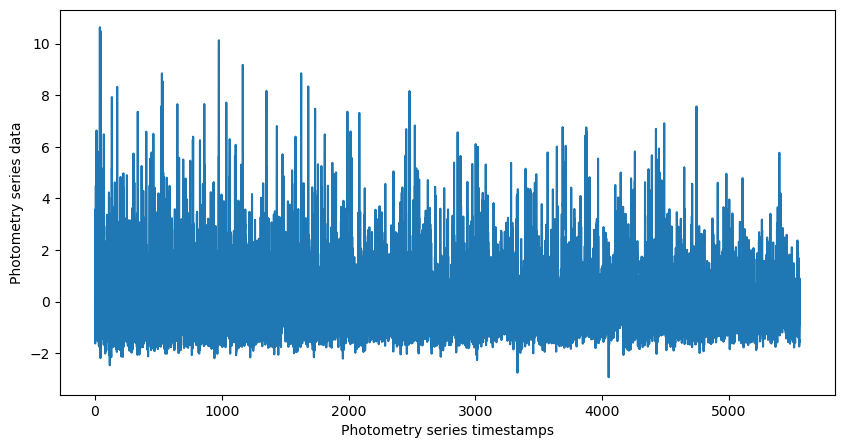

In [5]:
# Get hex path dataframe for the whole epoch
epoch_df = (HexPath & hex_path_key).fetch1_dataframe()
display(epoch_df)

# Fetch the a specific nwb FiberPhotometryResponseSeries object by name
series_name = "z_scored_green_dFF"
phot_series = FiberPhotometrySeries.fetch_series(nwb_file_name=nwb_file_name, series_name=series_name)

plt.figure(figsize = (10, 5))
plt.plot(phot_series.get_timestamps(), phot_series.data[:])
plt.xlabel('Photometry series timestamps')
plt.ylabel('Photometry series data')

In [6]:
epoch_df_dff = add_averaged_series_column(epoch_df, phot_series, new_col_name='avg_z_scored_green_dFF')
display(epoch_df_dff)

,nwb_file_name,epoch,block,block_trial_num,epoch_trial_num,hex,entry_time,exit_time,duration,hex_in_trial,hex_entry_num,hexes_from_start,hexes_from_end,hex_type,maze_portion,avg_z_scored_green_dFF
id,,,,,,,,,,,,,,,,
0,IM-1478_20220726_.nwb,0,1,1,1,49,49.924743,50.526743,0.602,1,1,-1,1,optimal,chosen,2.605692
1,IM-1478_20220726_.nwb,0,1,1,1,2,50.528743,54.334743,3.806,2,1,-1,0,optimal,chosen,0.967906
2,IM-1478_20220726_.nwb,0,1,2,2,2,54.336743,54.960743,0.624,1,1,0,14,optimal,start,0.817231
3,IM-1478_20220726_.nwb,0,1,2,2,49,54.962743,55.204743,0.242,2,1,1,13,optimal,start,-0.224777
4,IM-1478_20220726_.nwb,0,1,2,2,38,55.206743,55.800743,0.594,3,1,2,12,optimal,start,0.400566
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2965,IM-1478_20220726_.nwb,0,3,12,135,37,4363.960606,4364.056606,0.096,39,4,10,4,optimal,chosen,-0.872425
2966,IM-1478_20220726_.nwb,0,3,12,135,42,4364.058606,4364.368606,0.310,40,1,11,3,optimal,chosen,-0.941935
2967,IM-1478_20220726_.nwb,0,3,12,135,47,4364.370606,4364.686606,0.316,41,1,12,2,optimal,chosen,-0.544739


In [7]:
def filter_df_by_duration(HexPath_df, max_duration: float = 1.0):
    """
    Filter epochs based on minimum duration.
    """
    df = HexPath_df.copy()
    filtered_df = df[df['duration'] <= max_duration]
    
    return filtered_df

In [8]:
epoch_df_dff_duration_filtered = filter_df_by_duration(epoch_df_dff, max_duration = 1)
epoch_df_dff_duration_filtered

,nwb_file_name,epoch,block,block_trial_num,epoch_trial_num,hex,entry_time,exit_time,duration,hex_in_trial,hex_entry_num,hexes_from_start,hexes_from_end,hex_type,maze_portion,avg_z_scored_green_dFF
id,,,,,,,,,,,,,,,,
0,IM-1478_20220726_.nwb,0,1,1,1,49,49.924743,50.526743,0.602,1,1,-1,1,optimal,chosen,2.605692
2,IM-1478_20220726_.nwb,0,1,2,2,2,54.336743,54.960743,0.624,1,1,0,14,optimal,start,0.817231
3,IM-1478_20220726_.nwb,0,1,2,2,49,54.962743,55.204743,0.242,2,1,1,13,optimal,start,-0.224777
4,IM-1478_20220726_.nwb,0,1,2,2,38,55.206743,55.800743,0.594,3,1,2,12,optimal,start,0.400566
5,IM-1478_20220726_.nwb,0,1,2,2,32,55.802743,56.110743,0.308,4,1,3,11,optimal,start,-0.403063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2964,IM-1478_20220726_.nwb,0,3,12,135,32,4363.298606,4363.958606,0.660,38,5,11,3,optimal,chosen,-0.853009
2965,IM-1478_20220726_.nwb,0,3,12,135,37,4363.960606,4364.056606,0.096,39,4,10,4,optimal,chosen,-0.872425
2966,IM-1478_20220726_.nwb,0,3,12,135,42,4364.058606,4364.368606,0.310,40,1,11,3,optimal,chosen,-0.941935


### 2. Plot the ramp approaching to the goal (first, all of trials)
- epoch_df_dff has `hexes_from_end`, `hex_type`, and `hex_entry_num` to filter the hex to combine the `avg_z_scored_green_dff`
- we average the `avg_z_scored_green_dff` on the same of `hexes_from_end` when `'hex_type' == 'optimal'`, for now, ignore `hex_entry_num`

In [9]:
def weighted_mean_and_sem(HexPath_df, series_col: str = 'avg_z_scored_green_dFF', duration_col: str = 'duration'):
    """
    Compute duration-weighted mean and an approximate weighted SEM for one DataFrame (no grouping).
    Returns a pandas Series with keys: weighted_mean, weighted_sem, count, total_duration.
    """
    # drop rows with missing values in either column
    df = HexPath_df.dropna(subset=[series_col, duration_col])
    x = df[series_col].to_numpy(dtype=float)
    w = df[duration_col].to_numpy(dtype=float)
    n = x.size
    sum_w = w.sum()

    if n == 0:
        return pd.Series({'weighted_mean': np.nan, 'weighted_sem': np.nan, 'count': 0, 'total_duration': 0.0})

    # if total weight is zero we cannot compute a weighted mean/sem
    if sum_w == 0:
        return pd.Series({'weighted_mean': np.nan, 'weighted_sem': np.nan, 'count': int(n), 'total_duration': float(sum_w)})

    # weighted mean
    weighted_mean = np.average(x, weights=w)

    # population weighted variance: sum(w*(x-mu)^2)/sum(w)
    wvar = np.average((x - weighted_mean) ** 2, weights=w)
    sum_w2 = (w ** 2).sum()

    # effective sample size and sem
    n_eff = (sum_w ** 2) / sum_w2 if sum_w2 > 0 else np.nan
    weighted_sem = np.sqrt(wvar / n_eff) if (not np.isnan(n_eff) and n_eff > 0) else np.nan

    return pd.Series({
        'weighted_mean': float(weighted_mean),
        'weighted_sem': float(weighted_sem),
        'count': int(n),
        'total_duration': float(sum_w)
    })

In [10]:
def group_series_by_hexes_from_end(HexPath_df, series_col: str, hex_type=['optimal', 'non_optimal', 'dead_end'], maze_portion=['chosen', 'start', 'choice_point', 'unchosen'], pick_max_hex_entry_num=False):
    """
    Group series_name by hexes_from_end for rows with given hex_type.

    Parameters:
    - HexPath_df: pd.DataFrame with columns ['block','block_trial_num','hexes_from_end',
      'hex_type','hex_entry_num','averaged_series (manual column name)']
    - hex_type: filter by these hex_types, they have ['optimal', 'dead_end', 'non_optimal'] (default ['optimal'])
    - pick_max_hex_entry_num: if True, for each (block, block_trial_num, hexes_from_end)
      keep only the row with the max hex_entry_num (useful to pick last revisit)

    Returns:
    - dict mapping hexes_from_end -> list of series_col (NaNs are dropped)
    """

    df = HexPath_df.copy()

    if pick_max_hex_entry_num:
        # keep the last visit per trial/hexes_from_end (largest hex_entry_num)
        df = df.sort_values('hex_entry_num').drop_duplicates(
            subset=['block', 'block_trial_num', 'hexes_from_end'],
            keep='last'
        )

    # filter by hex_type
    if hex_type:
        df = df[df['hex_type'].isin(hex_type)]

    if maze_portion:
        df = df[df['maze_portion'].isin(maze_portion)]

    # group by hexes_from_end and 
    series_by_hexes_from_end = (df
             .groupby('hexes_from_end')
             .apply(lambda grouped_df: weighted_mean_and_sem(grouped_df, series_col, 'duration')))

    return series_by_hexes_from_end

In [11]:
# testing the data that passed the duration filter
dff_by_hexes_from_end = group_series_by_hexes_from_end(epoch_df_dff_duration_filtered, series_col='avg_z_scored_green_dFF', hex_type=['optimal'])
display(dff_by_hexes_from_end)

/tmp/ipykernel_3109949/487901835.py:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda grouped_df: weighted_mean_and_sem(grouped_df, series_col, 'duration')))


,weighted_mean,weighted_sem,count,total_duration
hexes_from_end,,,,
0,-0.243148,0.267650,6.0,3.534000
1,0.241697,0.064128,138.0,25.587999
2,0.080407,0.048862,134.0,35.591999
3,-0.103586,0.052023,137.0,41.877999
4,-0.168542,0.053297,139.0,51.041998
5,-0.172322,0.052196,145.0,36.171999
6,-0.293723,0.049149,127.0,46.063999
7,-0.425240,0.048764,122.0,47.325998
8,-0.427733,0.043358,143.0,47.011999


In [12]:
def plot_series_during_port_approach(series_by_hexes_from_end, series_col:str='weighted_mean', exclude_end_port=False, max_hexes_from_end=False, plot_sem=True, figsize=(10,5), figtitle:str='Average z-scored green dFF'):

    df = series_by_hexes_from_end.copy()
    
    if exclude_end_port:
        df = df.loc[df.index != 0]

    if max_hexes_from_end:
        df = df.loc[df.index <= max_hexes_from_end]
        
    plt.figure(figsize=figsize)
    plt.plot(df.index, df[series_col], label=series_col, color='C2')
    if plot_sem:
        plt.fill_between(df.index, df[series_col] - df['weighted_sem'], df[series_col] + df['weighted_sem'], color='C2', alpha=0.25, label='± weighted sem')
    plt.xlabel('Hexes from end')
    plt.ylabel(figtitle) # TODO: what if I want to plot the speed? how this function adjustable?
    # reverse x axis so it goes from max -> min
    plt.xlim(df.index.max(), df.index.min())
    plt.xticks(np.arange(df.index.max(), df.index.min()-1, -1))
    plt.legend()
    plt.show()

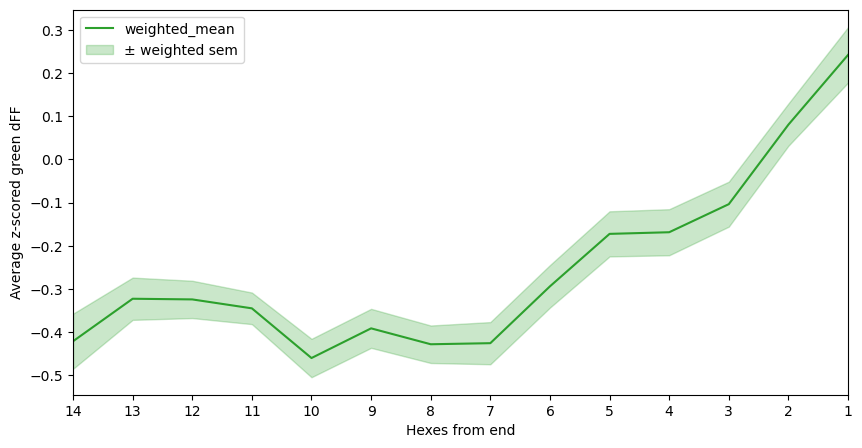

In [13]:
plot_series_during_port_approach(dff_by_hexes_from_end, series_col='weighted_mean', exclude_end_port=True, max_hexes_from_end=14) 

# Back To *RAMP* with Steph's newly populated table!
### 3. Get trial information based on conditions (rewarded? unrewarded? swr? no-swr? unrewarded_rewarded? rewarded_unrewarded?)

In [14]:
nwb_file_name = 'IM-1478_20220726_.nwb'
TrialHistory_df = pd.DataFrame((HexMazeTrialHistory() * HexMazeChoice() * HexMazeBlock().join_with_trial() & {'nwb_file_name': nwb_file_name}).fetch(as_dict=True)) # * sgc.Session()
TrialHistory_df.head()

,nwb_file_name,epoch,block,block_trial_num,port_visit_1prev_rwd,port_visit_2prev_rwd,port_visit_3prev_rwd,port_visit_1prev_same_path,port_visit_2prev_same_path,port_visit_3prev_same_path,...,num_trials,task_type,trial_interval_list_name,epoch_trial_num,reward,start_port,end_port,opto_cond,poke_interval,duration
0,IM-1478_20220726_.nwb,0,1,2,0,0,0,0,0,0,...,62,probability change,epoch0_block1_trial2,2,0,B,A,None,"[69.228, 74.12250240000337]",19.7859
1,IM-1478_20220726_.nwb,0,1,3,0,0,0,0,0,0,...,62,probability change,epoch0_block1_trial3,3,0,A,B,None,"[106.528, 108.44085760000348]",34.3184
2,IM-1478_20220726_.nwb,0,1,4,0,0,0,0,0,0,...,62,probability change,epoch0_block1_trial4,4,1,B,C,None,"[132.54, 140.2933951999992]",31.8525
3,IM-1478_20220726_.nwb,0,1,5,0,0,0,0,0,0,...,62,probability change,epoch0_block1_trial5,5,0,C,B,None,"[152.896, 164.43391999999434]",24.1405
4,IM-1478_20220726_.nwb,0,1,6,0,0,0,1,0,0,...,62,probability change,epoch0_block1_trial6,6,1,B,A,None,"[174.56, 189.60823039999605]",25.1743


In [15]:
def get_prev_current_dfs_by_conditions(
    HexPath_df: pd.DataFrame,
    HexMazeTrialHistory_df: pd.DataFrame,
    conditions: dict = None,
    *,
    skip_missing_filter_columns: bool = True,
) :
    """
    Return (prev_trial_df, current_trial_df) filtered from HexMazeTrialHistory_df according
    to the provided condition lists. Each parameter corresponds to a column in
    HexMazeTrialHistory_df and is used with `.isin(...)` when not None.

    prev_trial_df contains the rows whose `epoch_trial_num` equals
    current_trial_df['epoch_trial_num'] - 1 (i.e., the immediate previous trial).
    Both returned DataFrames are sorted by 'epoch_trial_num'.

    Parameters:
    - HexMazeTrialHistory_df: DataFrame with trial history (must contain relevant columns
      including 'epoch_trial_num').
    - Any of the keyword parameters: list of allowed values for that column. If
      a parameter is None, that column is not used for filtering.

    Returns:
    - prev_trial_df, current_trial_df (both pd.DataFrame)
    """
    hex_df = HexPath_df.copy()
    trial_df = HexMazeTrialHistory_df.copy() 
    
    if 'epoch_trial_num' not in trial_df.columns or 'epoch_trial_num' not in hex_df.columns:
        raise ValueError("Both inputs must contain 'epoch_trial_num'")

    # Apply filters based on provided conditions 
    for col, allowed_values in conditions.items():
        if allowed_values is not None:
            trial_df = trial_df[trial_df[col].isin(allowed_values)]
            
    # Create current and previous trial DataFrames
    current_epoch_trial_num = trial_df.epoch_trial_num.values
    prev_epoch_trial_num = current_epoch_trial_num - 1
    
    print(f"Total previous/current trials after filtering: {len(current_epoch_trial_num)} each")
    
    current_HexPath_df = hex_df[hex_df['epoch_trial_num'].isin(current_epoch_trial_num)].copy()
    prev_HexPath_df = hex_df[hex_df['epoch_trial_num'].isin(prev_epoch_trial_num)].copy()
    
    return prev_HexPath_df, current_HexPath_df
    

In [16]:
conditions_to_filter = {
    'port_visit_2prev_rwd': [0],
    'port_visit_1prev_rwd': [1],
    'trials_since_port_visit' : [2, 3],
}

prev_epoch_df_dff_duration_condition_filtered, current_epoch_df_dff_duration_condition_filtered = get_prev_current_dfs_by_conditions(epoch_df_dff_duration_filtered, TrialHistory_df, conditions_to_filter)
print(conditions_to_filter)
display(prev_epoch_df_dff_duration_condition_filtered.head())
display(current_epoch_df_dff_duration_condition_filtered.head())    

Total previous/current trials after filtering: 17 each
{'port_visit_2prev_rwd': [0], 'port_visit_1prev_rwd': [1], 'trials_since_port_visit': [2, 3]}


,nwb_file_name,epoch,block,block_trial_num,epoch_trial_num,hex,entry_time,exit_time,duration,hex_in_trial,hex_entry_num,hexes_from_start,hexes_from_end,hex_type,maze_portion,avg_z_scored_green_dFF
id,,,,,,,,,,,,,,,,
94,IM-1478_20220726_.nwb,0,1,6,6,2,164.43474,164.87674,0.442,1,1,0,14,optimal,start,-1.089305
95,IM-1478_20220726_.nwb,0,1,6,6,49,164.87874,165.06674,0.188,2,1,1,13,optimal,start,-1.346668
96,IM-1478_20220726_.nwb,0,1,6,6,38,165.06874,165.39474,0.326,3,1,2,12,optimal,start,-0.419976
97,IM-1478_20220726_.nwb,0,1,6,6,32,165.39674,165.70474,0.308,4,1,3,11,optimal,start,-0.284117
98,IM-1478_20220726_.nwb,0,1,6,6,37,165.70674,165.85674,0.150,5,1,4,10,optimal,start,-0.340675


,nwb_file_name,epoch,block,block_trial_num,epoch_trial_num,hex,entry_time,exit_time,duration,hex_in_trial,hex_entry_num,hexes_from_start,hexes_from_end,hex_type,maze_portion,avg_z_scored_green_dFF
id,,,,,,,,,,,,,,,,
109,IM-1478_20220726_.nwb,0,1,7,7,1,189.608739,190.076739,0.468,1,1,0,16,optimal,start,-1.069629
110,IM-1478_20220726_.nwb,0,1,7,7,4,190.078739,190.786739,0.708,2,1,1,15,optimal,start,-0.607818
111,IM-1478_20220726_.nwb,0,1,7,7,1,190.788739,191.104739,0.316,3,2,0,16,optimal,start,-0.060217
112,IM-1478_20220726_.nwb,0,1,7,7,4,191.106739,191.538739,0.432,4,2,1,15,optimal,start,-0.189375
113,IM-1478_20220726_.nwb,0,1,7,7,6,191.540739,191.754739,0.214,5,1,2,14,optimal,start,-1.031131


#### 4. Plot the ramp given that information of trials

In [17]:
prev_dff_by_hexes_from_end = group_series_by_hexes_from_end(prev_epoch_df_dff_duration_condition_filtered, series_col = 'avg_z_scored_green_dFF', hex_type=['optimal'])
current_dff_by_hexes_from_end = group_series_by_hexes_from_end(current_epoch_df_dff_duration_condition_filtered, series_col = 'avg_z_scored_green_dFF', hex_type=['optimal'])
print(conditions_to_filter)
print(prev_dff_by_hexes_from_end)
print(current_dff_by_hexes_from_end)

{'port_visit_2prev_rwd': [0], 'port_visit_1prev_rwd': [1], 'trials_since_port_visit': [2, 3]}
                weighted_mean  weighted_sem  count  total_duration
hexes_from_end                                                    
1                    0.355908      0.167429   17.0           2.940
2                    0.246059      0.136605   17.0           4.670
3                   -0.081203      0.122796   16.0           4.156
4                   -0.353055      0.091561   16.0           6.058
5                   -0.175248      0.212729   19.0           4.264
6                   -0.260851      0.164891   18.0           6.056
7                   -0.392362      0.121294   18.0           8.370
8                   -0.511695      0.090675   19.0           5.758
9                   -0.396475      0.135095   21.0           9.316
10                  -0.518082      0.103983   19.0           6.070
11                  -0.417747      0.074203   14.0           4.090
12                  -0.252850      

/tmp/ipykernel_3109949/487901835.py:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda grouped_df: weighted_mean_and_sem(grouped_df, series_col, 'duration')))
/tmp/ipykernel_3109949/487901835.py:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda grouped_df: weighted_mean_and_sem(grouped_df, series_col, 'duration')))


In [18]:
def plot_two_series_during_port_approach(prev_series_by_hexes_from_end, current_series_by_hexes_from_end, series_col:str='weighted_mean', exclude_end_port=False, max_hexes_from_end=False, plot_sem=True, figsize=(10,5), figtitle:str='Average z-scored green dFF'):

    prev_df = prev_series_by_hexes_from_end.copy()
    current_df = current_series_by_hexes_from_end.copy()
    
    if exclude_end_port:
        prev_df = prev_df.loc[prev_df.index != 0]
        current_df = current_df.loc[current_df.index != 0]

    if max_hexes_from_end:
        prev_df = prev_df.loc[prev_df.index <= max_hexes_from_end]
        current_df = current_df.loc[current_df.index <= max_hexes_from_end]
        
    plt.figure(figsize=figsize)
    plt.plot(prev_df.index, prev_df[series_col], label='Previous', color='C7')
    plt.plot(current_df.index, current_df[series_col], label='Current', color='C0')
    if plot_sem:
        plt.fill_between(prev_df.index, prev_df[series_col] - prev_df['weighted_sem'], prev_df[series_col] + prev_df['weighted_sem'], color='C7', alpha=0.25, label='± weighted sem')
        plt.fill_between(current_df.index, current_df[series_col] - current_df['weighted_sem'], current_df[series_col] + current_df['weighted_sem'], color='C0', alpha=0.25, label='± weighted sem')
    plt.xlabel('Hexes from end')
    plt.ylabel(figtitle)
    # reverse x axis so it goes from max -> min
    plt.xlim(prev_df.index.max(), prev_df.index.min())
    plt.xticks(np.arange(prev_df.index.max(), prev_df.index.min()-1, -1))
    plt.legend()
    plt.show()

{'port_visit_2prev_rwd': [0], 'port_visit_1prev_rwd': [1], 'trials_since_port_visit': [2, 3]}


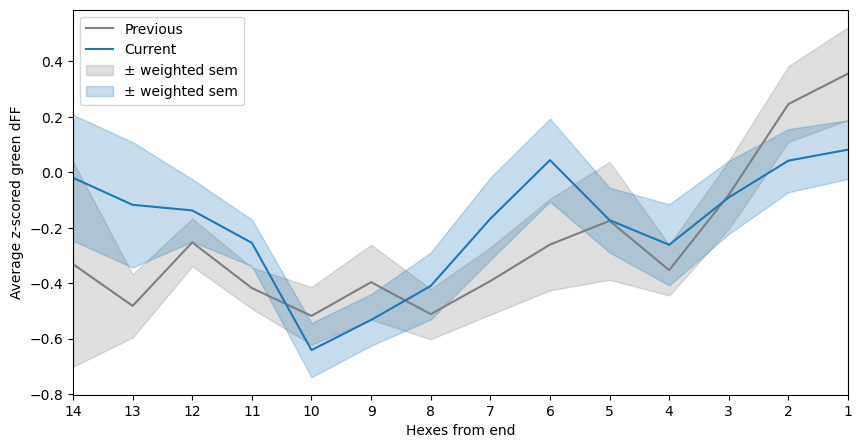

In [19]:
print(conditions_to_filter)
plot_two_series_during_port_approach(prev_dff_by_hexes_from_end, current_dff_by_hexes_from_end, max_hexes_from_end=14, figtitle='Average z-scored green dFF')

### trying another condition

In [32]:
conditions_to_filter = {
    'port_visit_2prev_rwd': [1],
    'port_visit_1prev_rwd': [0],
    'trials_since_port_visit' : [2, 3],
}

prev_epoch_df_dff_duration_condition_filtered, current_epoch_df_dff_duration_condition_filtered = get_prev_current_dfs_by_conditions(epoch_df_dff_duration_filtered, TrialHistory_df, conditions_to_filter)
print(conditions_to_filter)
display(prev_epoch_df_dff_duration_condition_filtered.head())
display(current_epoch_df_dff_duration_condition_filtered.head())    

Total previous/current trials after filtering: 18 each
{'port_visit_2prev_rwd': [1], 'port_visit_1prev_rwd': [0], 'trials_since_port_visit': [2, 3]}


,nwb_file_name,epoch,block,block_trial_num,epoch_trial_num,hex,entry_time,exit_time,duration,hex_in_trial,hex_entry_num,hexes_from_start,hexes_from_end,hex_type,maze_portion,avg_z_scored_green_dFF
id,,,,,,,,,,,,,,,,
247,IM-1478_20220726_.nwb,0,1,12,12,1,347.890734,348.216734,0.326,1,1,0,14,optimal,start,-0.559797
249,IM-1478_20220726_.nwb,0,1,12,12,6,349.558734,349.748734,0.190,3,1,2,12,optimal,start,0.039041
250,IM-1478_20220726_.nwb,0,1,12,12,8,349.750734,350.212734,0.462,4,1,3,11,optimal,start,-0.813839
251,IM-1478_20220726_.nwb,0,1,12,12,10,350.214734,350.316734,0.102,5,1,4,10,optimal,start,-1.482311
252,IM-1478_20220726_.nwb,0,1,12,12,13,350.318734,350.698734,0.380,6,1,5,9,optimal,start,-1.109214


,nwb_file_name,epoch,block,block_trial_num,epoch_trial_num,hex,entry_time,exit_time,duration,hex_in_trial,hex_entry_num,hexes_from_start,hexes_from_end,hex_type,maze_portion,avg_z_scored_green_dFF
id,,,,,,,,,,,,,,,,
262,IM-1478_20220726_.nwb,0,1,13,13,2,354.438734,354.946734,0.508,1,1,0,16,optimal,start,-0.119720
263,IM-1478_20220726_.nwb,0,1,13,13,49,354.948734,354.954734,0.006,2,1,1,15,optimal,start,-0.351828
264,IM-1478_20220726_.nwb,0,1,13,13,2,354.956734,355.220734,0.264,3,2,0,16,optimal,start,0.338873
265,IM-1478_20220726_.nwb,0,1,13,13,49,355.222734,355.290734,0.068,4,2,1,15,optimal,start,2.204304
268,IM-1478_20220726_.nwb,0,1,13,13,38,360.898734,361.414734,0.516,7,1,2,14,optimal,start,-0.133880


In [33]:
prev_dff_by_hexes_from_end = group_series_by_hexes_from_end(prev_epoch_df_dff_duration_condition_filtered, series_col = 'avg_z_scored_green_dFF', hex_type=['optimal'])
current_dff_by_hexes_from_end = group_series_by_hexes_from_end(current_epoch_df_dff_duration_condition_filtered, series_col = 'avg_z_scored_green_dFF', hex_type=['optimal'])
print(conditions_to_filter)
print(prev_dff_by_hexes_from_end)
print(current_dff_by_hexes_from_end)

{'port_visit_2prev_rwd': [1], 'port_visit_1prev_rwd': [0], 'trials_since_port_visit': [2, 3]}
                weighted_mean  weighted_sem  count  total_duration
hexes_from_end                                                    
1                    0.336730      0.171599   18.0           3.166
2                    0.115103      0.183214   18.0           4.158
3                   -0.090112      0.128156   18.0           5.196
4                   -0.209490      0.148586   16.0           6.726
5                   -0.273860      0.103431   17.0           4.122
6                   -0.231688      0.145229   15.0           5.306
7                   -0.479987      0.149232   16.0           5.768
8                   -0.391727      0.115836   16.0           4.954
9                   -0.428178      0.097182   16.0           6.428
10                  -0.386558      0.110432   16.0           3.310
11                  -0.300571      0.106279   20.0           8.070
12                  -0.489457      

/tmp/ipykernel_3109949/487901835.py:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda grouped_df: weighted_mean_and_sem(grouped_df, series_col, 'duration')))
/tmp/ipykernel_3109949/487901835.py:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda grouped_df: weighted_mean_and_sem(grouped_df, series_col, 'duration')))


{'port_visit_2prev_rwd': [1], 'port_visit_1prev_rwd': [0], 'trials_since_port_visit': [2, 3]}


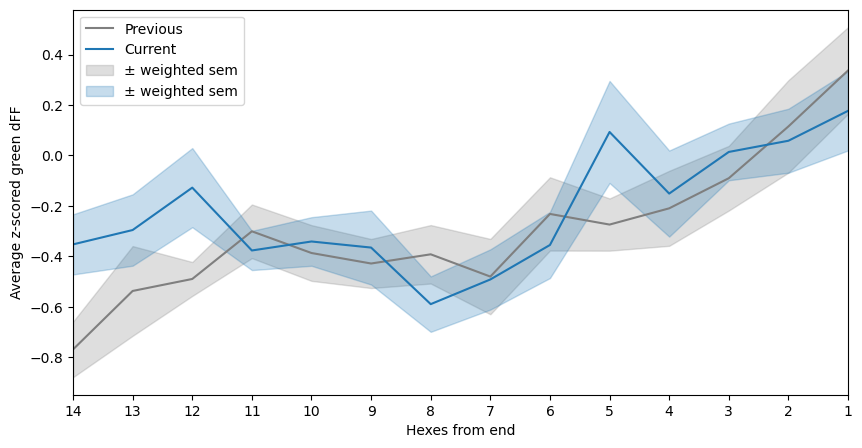

In [34]:
print(conditions_to_filter)
plot_two_series_during_port_approach(prev_dff_by_hexes_from_end, current_dff_by_hexes_from_end, max_hexes_from_end=14, figtitle='Average z-scored green dFF')

{'port_visit_2prev_rwd': [1], 'port_visit_1prev_rwd': [0]}


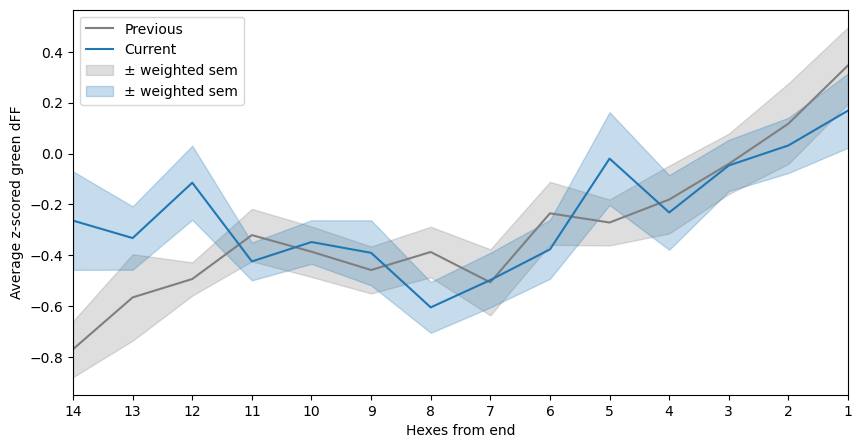

In [22]:
print(conditions_to_filter)
plot_two_series_during_port_approach(prev_dff_by_hexes_from_end, current_dff_by_hexes_from_end, max_hexes_from_end=14, figtitle='Average z-scored green dFF')

# Speed plot
1. Directly using epoch_df and it's duration with size of the hex (13 cm)


In [23]:
def add_speed_column_by_duration(HexPath_df, new_col_name: str, hex_size: int = 13):
    """
    Add a speed column computed as hex_size / duration.
    Args:
        HexPath_df: DataFrame with a 'duration' column.
        new_col_name: name for the new speed column.
        hex_size: size (distance) of a hex (default 13).
    """
    df = HexPath_df.copy()
    speeds = []

    for _, row in df.iterrows():
        duration = row.get('duration', np.nan)
        try:
            duration = float(duration)
        except Exception:
            duration = np.nan

        if np.isfinite(duration) and duration > 0:
            speed = hex_size / duration
        else:
            speed = np.nan

        speeds.append(speed)

    df[new_col_name] = speeds
    return df

In [24]:
epoch_df_dff_speed = add_speed_column_by_duration(epoch_df_dff, hex_size=13, new_col_name='speed')
epoch_df_dff_speed

,nwb_file_name,epoch,block,block_trial_num,epoch_trial_num,hex,entry_time,exit_time,duration,hex_in_trial,hex_entry_num,hexes_from_start,hexes_from_end,hex_type,maze_portion,avg_z_scored_green_dFF,speed
id,,,,,,,,,,,,,,,,,
0,IM-1478_20220726_.nwb,0,1,1,1,49,49.924743,50.526743,0.602,1,1,-1,1,optimal,chosen,2.605692,21.594685
1,IM-1478_20220726_.nwb,0,1,1,1,2,50.528743,54.334743,3.806,2,1,-1,0,optimal,chosen,0.967906,3.415660
2,IM-1478_20220726_.nwb,0,1,2,2,2,54.336743,54.960743,0.624,1,1,0,14,optimal,start,0.817231,20.833334
3,IM-1478_20220726_.nwb,0,1,2,2,49,54.962743,55.204743,0.242,2,1,1,13,optimal,start,-0.224777,53.719010
4,IM-1478_20220726_.nwb,0,1,2,2,38,55.206743,55.800743,0.594,3,1,2,12,optimal,start,0.400566,21.885523
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2965,IM-1478_20220726_.nwb,0,3,12,135,37,4363.960606,4364.056606,0.096,39,4,10,4,optimal,chosen,-0.872425,135.416671
2966,IM-1478_20220726_.nwb,0,3,12,135,42,4364.058606,4364.368606,0.310,40,1,11,3,optimal,chosen,-0.941935,41.935485
2967,IM-1478_20220726_.nwb,0,3,12,135,47,4364.370606,4364.686606,0.316,41,1,12,2,optimal,chosen,-0.544739,41.139242


In [25]:
speed_by_hexes_from_end = group_series_by_hexes_from_end(epoch_df_dff_speed, series_col='speed', hex_type=['optimal','choice_point'])
display(speed_by_hexes_from_end)

/tmp/ipykernel_3109949/487901835.py:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda grouped_df: weighted_mean_and_sem(grouped_df, series_col, 'duration')))


,weighted_mean,weighted_sem,count,total_duration
hexes_from_end,,,,
0,1.859942,0.405145,138.0,964.545969
1,43.292396,10.706111,141.0,42.339999
2,44.690356,1.797558,137.0,39.851999
3,34.765860,3.529434,143.0,53.471998
4,11.770392,4.355508,163.0,180.027994
5,18.449323,12.347842,158.0,111.331996
6,20.424641,3.101883,144.0,91.653997
7,17.149473,2.633656,147.0,111.431996
8,20.068831,4.754223,157.0,101.699997


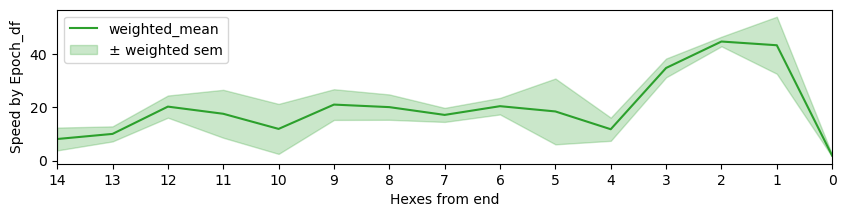

In [26]:
plot_series_during_port_approach(speed_by_hexes_from_end, series_col='weighted_mean', exclude_end_port=False, max_hexes_from_end=14, figtitle='Speed by Epoch_df', figsize=(10,2)) 

2. Using velocity data from HexPosition table

In [27]:
from hex_maze_behavior import HexPosition

pos_key = {
    'pos_merge_id': "cfe6c111-1aa1-a41d-858c-f307e7a53b7c", 
    'nwb_file_name': 'IM-1478_20220726_.nwb', 
    'epoch': 0
}

display(HexPosition() & pos_key)

# Fetch rat's position + assigned hex
hex_and_pos_df = (HexPosition() & pos_key).fetch_hex_and_position_dataframe()
display(hex_and_pos_df)

pos_merge_id,nwb_file_name name of the NWB file,epoch the session epoch for this task and apparatus(1 based),analysis_file_name name of the file,hex_assignment_object_id
cfe6c111-1aa1-a41d-858c-f307e7a53b7c,IM-1478_20220726_.nwb,0,IM-1478_20220726_QVH88J6G2L.nwb,6713169f-da4e-412f-93c5-e709fce6ad7f


[17:38:14][WARNING] Spyglass: Upsampled position data, frame indices are invalid. Setting add_frame_ind=False


,position_x,position_y,orientation,velocity_x,velocity_y,speed,hex,hex_including_sides,distance_from_centroid
time,,,,,,,,,
49.924743,48.875865,126.927501,-2.828533,-6.552273,-11.494208,13.230612,49,49,6.594894
49.926743,48.855970,126.885491,-2.826981,-6.491748,-11.364589,13.088036,49,49,6.555677
49.928743,48.836074,126.843481,-2.825451,-6.430658,-11.232507,12.943052,49,49,6.516555
49.930743,48.816178,126.801471,-2.823943,-6.369021,-11.098029,12.795729,49,49,6.477530
49.932743,48.796282,126.759461,-2.822456,-6.306857,-10.961224,12.646141,49,49,6.438604
...,...,...,...,...,...,...,...,...,...
4373.816606,33.987062,129.762182,2.767999,5.172852,-6.221110,8.090773,2,2,6.777932
4373.818606,34.000927,129.758267,2.770006,5.240502,-6.331527,8.218947,2,2,6.763533
4373.820606,34.014791,129.754352,2.772013,5.307450,-6.441350,8.346258,2,2,6.749134


In [28]:
def add_averaged_speed_column(HexPath_df, HexPosition_df, new_col_name: str):
    """
    Calculate the average speed between each hex's entry_time and exit_time.

    Parameters:
    HexPath_df (pd.DataFrame): DataFrame containing hex path data with 'entry_time' and 'exit_time' columns.
    HexPosition_df (pd.DataFrame): DataFrame containing position data with timestamps and speed.

    Returns:
    pd.DataFrame: Updated DataFrame with a new column specified by col_name.
    """
    df = HexPath_df.copy()
    avg_series_list = []

    timestamps = HexPosition_df.index.values
    data = HexPosition_df.speed.values

    for _, row in df.iterrows():
        entry_time = row['entry_time']
        exit_time = row['exit_time']

        # Find indices of timestamps within the entry and exit time
        indices = np.where((timestamps >= entry_time) & (timestamps <= exit_time))[0]

        if len(indices) > 0:
            avg_speed = np.mean(data[indices])
        else:
            avg_speed = np.nan  # No data in this interval

        avg_series_list.append(avg_speed)

    df[new_col_name] = avg_series_list
    return df

In [29]:
epoch_df_dff_speed_avg = add_averaged_speed_column(epoch_df_dff_speed, hex_and_pos_df, new_col_name='avg_speed')
epoch_df_dff_speed_avg

,nwb_file_name,epoch,block,block_trial_num,epoch_trial_num,hex,entry_time,exit_time,duration,hex_in_trial,hex_entry_num,hexes_from_start,hexes_from_end,hex_type,maze_portion,avg_z_scored_green_dFF,speed,avg_speed
id,,,,,,,,,,,,,,,,,,
0,IM-1478_20220726_.nwb,0,1,1,1,49,49.924743,50.526743,0.602,1,1,-1,1,optimal,chosen,2.605692,21.594685,4.528278
1,IM-1478_20220726_.nwb,0,1,1,1,2,50.528743,54.334743,3.806,2,1,-1,0,optimal,chosen,0.967906,3.415660,5.705526
2,IM-1478_20220726_.nwb,0,1,2,2,2,54.336743,54.960743,0.624,1,1,0,14,optimal,start,0.817231,20.833334,14.179046
3,IM-1478_20220726_.nwb,0,1,2,2,49,54.962743,55.204743,0.242,2,1,1,13,optimal,start,-0.224777,53.719010,40.036868
4,IM-1478_20220726_.nwb,0,1,2,2,38,55.206743,55.800743,0.594,3,1,2,12,optimal,start,0.400566,21.885523,21.198948
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2965,IM-1478_20220726_.nwb,0,3,12,135,37,4363.960606,4364.056606,0.096,39,4,10,4,optimal,chosen,-0.872425,135.416671,33.813254
2966,IM-1478_20220726_.nwb,0,3,12,135,42,4364.058606,4364.368606,0.310,40,1,11,3,optimal,chosen,-0.941935,41.935485,32.235046
2967,IM-1478_20220726_.nwb,0,3,12,135,47,4364.370606,4364.686606,0.316,41,1,12,2,optimal,chosen,-0.544739,41.139242,39.522115


In [30]:
avg_speed_by_hexes_from_end = group_series_by_hexes_from_end(epoch_df_dff_speed_avg, series_col='avg_speed', hex_type=['optimal','choice_point'])
display(avg_speed_by_hexes_from_end)

/tmp/ipykernel_3109949/487901835.py:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda grouped_df: weighted_mean_and_sem(grouped_df, series_col, 'duration')))


,weighted_mean,weighted_sem,count,total_duration
hexes_from_end,,,,
0,3.804943,0.243669,138.0,964.545969
1,29.231592,5.769726,141.0,42.339999
2,39.311151,1.220829,137.0,39.851999
3,27.556015,1.610110,143.0,53.471998
4,13.328939,2.834455,163.0,180.027994
5,12.238388,4.737219,158.0,111.331996
6,19.510704,2.406745,144.0,91.653997
7,15.403089,1.630327,147.0,111.431996
8,16.541069,3.105567,157.0,101.699997


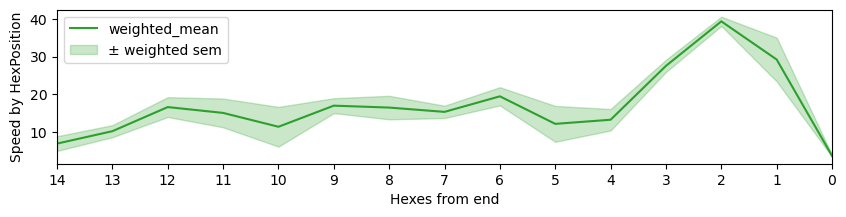

In [31]:
plot_series_during_port_approach(avg_speed_by_hexes_from_end, series_col='weighted_mean', exclude_end_port=False, max_hexes_from_end=14, figtitle='Speed by HexPosition', figsize=(10,2)) 